Exploring environment

In [1]:
import random
import copy
import os
import imageio
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym


env = gym.make("CartPole-v1", render_mode="rgb_array")

In [2]:
env.spec

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [3]:
print(env.observation_space)
print(env.observation_space.shape[0])

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
4


In [4]:
print(env.action_space)
print(env.action_space.n)

Discrete(2)
2


In [5]:
print(env.action_space.sample())
print(env.observation_space.sample())

0
[-4.0492587  -0.8577661   0.37529805  0.20126891]


In [6]:
obs,info = env.reset()

In [7]:
torch.tensor(obs,dtype=torch.float32).unsqueeze(0).shape

torch.Size([1, 4])

In [8]:
info

{}

In [9]:
total_reward = 0
obs,info = env.reset()
for step in range(1000):
  action = env.action_space.sample()
  obs,reward,terminated,truncated,info=env.step(action)
  total_reward = total_reward + reward
  print(obs,reward,terminated,truncated,step)
  if terminated or truncated:
    break
print(total_reward)

[ 0.03726007  0.21352299 -0.00313533 -0.29509905] 1.0 False False 0
[ 0.04153053  0.4086895  -0.00903731 -0.58876914] 1.0 False False 1
[ 0.04970432  0.60393685 -0.02081269 -0.8842851 ] 1.0 False False 2
[ 0.06178306  0.7993351  -0.03849839 -1.1834376 ] 1.0 False False 3
[ 0.07776976  0.99493486 -0.06216715 -1.4879355 ] 1.0 False False 4
[ 0.09766845  1.1907566  -0.09192585 -1.799366  ] 1.0 False False 5
[ 0.12148359  0.9967752  -0.12791318 -1.5366107 ] 1.0 False False 6
[ 0.14141908  0.80340415 -0.15864539 -1.2864279 ] 1.0 False False 7
[ 0.15748717  1.000149   -0.18437394 -1.6242853 ] 1.0 False False 8
[ 0.17749016  1.1968999  -0.21685965 -1.9683089 ] 1.0 True False 9
10.0


Training Double DQN

In [10]:

class Q_Network(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size,hidden_size)
    self.fc2 = nn.Linear(hidden_size,hidden_size)
    self.fc3 = nn.Linear(hidden_size,output_size)

  def forward(self,x):
    x = self.fc1(x)
    x = nn.ReLU()(x)
    x = self.fc2(x)
    x= nn.ReLU()(x)
    x = self.fc3(x)
    return x


In [11]:


class ReplayBuffer():
  def __init__(self,capacity,device):
    self.buffer = deque(maxlen=capacity)
    self.device = device

  def add(self,state,action,reward,next_state,done):
    self.buffer.append((state,action,reward,next_state,done))


  def sample(self,batch_size):
    batch = random.sample(self.buffer,batch_size)
    states,actions,rewards,next_states,dones = zip(*batch)

    return (
        torch.tensor(states,dtype=torch.float32,device=self.device),
        torch.tensor(actions,dtype=torch.int32,device=self.device),
        torch.tensor(rewards,dtype=torch.float32,device=self.device),
        torch.tensor(next_states,dtype=torch.float32,device=self.device),
        torch.tensor(dones,dtype=torch.float32,device=self.device)
    )

  def len(self):
    return len(self.buffer)



In [12]:
os.makedirs("results", exist_ok=True)
MODEL_DIR = "./results/models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "dqn_model.pt")


def evaluate_and_record(env, q_net, device, max_steps=1000):
    q_net.eval()
    frames = []
    state, _ = env.reset()
    total_reward = 0

    for _ in range(max_steps):
        frame = env.render()
        if frame is not None:
            frames.append(frame)

        with torch.no_grad():
            q_vals = q_net(
                torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            )
            action = torch.argmax(q_vals).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    q_net.train()
    frames = np.array(frames)
    print(f"Evaluation Reward: {total_reward:7.2f}")
    return total_reward, frames


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q_net = Q_Network(
    input_size=env.observation_space.shape[0],
    hidden_size=64,
    output_size=env.action_space.n,
).to(device)

target_q_net = copy.deepcopy(q_net).to(device)
target_q_net.eval()

optimizer = optim.Adam(q_net.parameters(), lr=1e-3)
loss_fn = nn.SmoothL1Loss()

buffer = ReplayBuffer(capacity=50_000, device=device)

num_episodes = 2000
batch_size = 32
gamma = 0.99

epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995

eval_every = 100
tau = 0.005

reward_list = []
epsilon_list = []
eval_rewards = []

SOLVED_REWARD = 425
SOLVED_WINDOW = 3

for eps in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0

    for step in range(1000):
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_vals = q_net(
                    torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                )
                action = torch.argmax(q_vals).item()

        next_state, reward, terminated, truncated, _ = env.step(action)

        buffer.add(state, action, reward, next_state, terminated or truncated)
        state = next_state
        total_reward += reward

        if buffer.len() >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)

            with torch.no_grad():
                next_actions = torch.argmax(q_net(next_states), dim=1)
                next_q = target_q_net(next_states).gather(
                    1, next_actions.unsqueeze(1)
                ).squeeze(1)
                targets = rewards + gamma * next_q * (1 - dones)

            q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            loss = loss_fn(q_values, targets)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=10.0)
            optimizer.step()

            for target_param, param in zip(target_q_net.parameters(), q_net.parameters()):
                target_param.data.copy_(
                    tau * param.data + (1 - tau) * target_param.data
                )

        if terminated or truncated:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    reward_list.append(total_reward)
    epsilon_list.append(epsilon)

    print(f"Episode {eps:4d} | Reward: {total_reward:7.2f} | Epsilon: {epsilon:.3f}")

    if len(reward_list) >= SOLVED_WINDOW:
        avg_reward = np.mean(reward_list[-SOLVED_WINDOW:])
        if avg_reward >= SOLVED_REWARD:
            print(f"SOLVED at episode {eps}")
            torch.save(
                {
                    "episode": eps,
                    "model_state_dict": q_net.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "epsilon": epsilon,
                    "avg_reward_100": avg_reward,
                },
                MODEL_PATH,
            )
            break

    if eps % eval_every == 0:
        eval_reward, frames = evaluate_and_record(env, q_net, device)
        eval_rewards.append(eval_reward)

        video_path = f"./results/eval_ep{eps}.mp4"
        imageio.mimsave(video_path, frames, fps=30)

env.close()


Episode    0 | Reward:   19.00 | Epsilon: 0.995
Evaluation Reward:    8.00


/tmp/ipython-input-3246115743.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  torch.tensor(states,dtype=torch.float32,device=self.device),


Episode    1 | Reward:   34.00 | Epsilon: 0.990
Episode    2 | Reward:   23.00 | Epsilon: 0.985
Episode    3 | Reward:   19.00 | Epsilon: 0.980
Episode    4 | Reward:   35.00 | Epsilon: 0.975
Episode    5 | Reward:   17.00 | Epsilon: 0.970
Episode    6 | Reward:   36.00 | Epsilon: 0.966
Episode    7 | Reward:   18.00 | Epsilon: 0.961
Episode    8 | Reward:   23.00 | Epsilon: 0.956
Episode    9 | Reward:   20.00 | Epsilon: 0.951
Episode   10 | Reward:   15.00 | Epsilon: 0.946
Episode   11 | Reward:   21.00 | Epsilon: 0.942
Episode   12 | Reward:   16.00 | Epsilon: 0.937
Episode   13 | Reward:   32.00 | Epsilon: 0.932
Episode   14 | Reward:   15.00 | Epsilon: 0.928
Episode   15 | Reward:   13.00 | Epsilon: 0.923
Episode   16 | Reward:   22.00 | Epsilon: 0.918
Episode   17 | Reward:   30.00 | Epsilon: 0.914
Episode   18 | Reward:   16.00 | Epsilon: 0.909
Episode   19 | Reward:   30.00 | Epsilon: 0.905
Episode   20 | Reward:   20.00 | Epsilon: 0.900
Episode   21 | Reward:   35.00 | Epsilon

Evaluation Reward:  199.00
Episode  101 | Reward:  103.00 | Epsilon: 0.600
Episode  102 | Reward:   26.00 | Epsilon: 0.597
Episode  103 | Reward:  126.00 | Epsilon: 0.594
Episode  104 | Reward:   37.00 | Epsilon: 0.591
Episode  105 | Reward:   38.00 | Epsilon: 0.588
Episode  106 | Reward:  114.00 | Epsilon: 0.585
Episode  107 | Reward:   22.00 | Epsilon: 0.582
Episode  108 | Reward:   43.00 | Epsilon: 0.579
Episode  109 | Reward:   56.00 | Epsilon: 0.576
Episode  110 | Reward:   83.00 | Epsilon: 0.573
Episode  111 | Reward:   11.00 | Epsilon: 0.570
Episode  112 | Reward:   58.00 | Epsilon: 0.568
Episode  113 | Reward:   55.00 | Epsilon: 0.565
Episode  114 | Reward:   13.00 | Epsilon: 0.562
Episode  115 | Reward:   67.00 | Epsilon: 0.559
Episode  116 | Reward:  138.00 | Epsilon: 0.556
Episode  117 | Reward:   89.00 | Epsilon: 0.554
Episode  118 | Reward:   77.00 | Epsilon: 0.551
Episode  119 | Reward:   68.00 | Epsilon: 0.548
Episode  120 | Reward:   93.00 | Epsilon: 0.545
Episode  121 

Evaluation Reward:  113.00
Episode  201 | Reward:   16.00 | Epsilon: 0.363
Episode  202 | Reward:   13.00 | Epsilon: 0.361
Episode  203 | Reward:   16.00 | Epsilon: 0.360
Episode  204 | Reward:   40.00 | Epsilon: 0.358
Episode  205 | Reward:   53.00 | Epsilon: 0.356
Episode  206 | Reward:   56.00 | Epsilon: 0.354
Episode  207 | Reward:  113.00 | Epsilon: 0.353
Episode  208 | Reward:   20.00 | Epsilon: 0.351
Episode  209 | Reward:  318.00 | Epsilon: 0.349
Episode  210 | Reward:   29.00 | Epsilon: 0.347
Episode  211 | Reward:   14.00 | Epsilon: 0.346
Episode  212 | Reward:   76.00 | Epsilon: 0.344
Episode  213 | Reward:   90.00 | Epsilon: 0.342
Episode  214 | Reward:   13.00 | Epsilon: 0.340
Episode  215 | Reward:  110.00 | Epsilon: 0.339
Episode  216 | Reward:   68.00 | Epsilon: 0.337
Episode  217 | Reward:   13.00 | Epsilon: 0.335
Episode  218 | Reward:   14.00 | Epsilon: 0.334
Episode  219 | Reward:   28.00 | Epsilon: 0.332
Episode  220 | Reward:   20.00 | Epsilon: 0.330
Episode  221 

Evaluation Reward:   92.00
Episode  301 | Reward:   20.00 | Epsilon: 0.220
Episode  302 | Reward:   94.00 | Epsilon: 0.219
Episode  303 | Reward:   12.00 | Epsilon: 0.218
Episode  304 | Reward:   20.00 | Epsilon: 0.217
Episode  305 | Reward:   49.00 | Epsilon: 0.216
Episode  306 | Reward:   14.00 | Epsilon: 0.215
Episode  307 | Reward:   12.00 | Epsilon: 0.214
Episode  308 | Reward:   93.00 | Epsilon: 0.212
Episode  309 | Reward:   78.00 | Epsilon: 0.211
Episode  310 | Reward:   19.00 | Epsilon: 0.210
Episode  311 | Reward:   41.00 | Epsilon: 0.209
Episode  312 | Reward:   76.00 | Epsilon: 0.208
Episode  313 | Reward:   98.00 | Epsilon: 0.207
Episode  314 | Reward:   12.00 | Epsilon: 0.206
Episode  315 | Reward:   27.00 | Epsilon: 0.205
Episode  316 | Reward:   13.00 | Epsilon: 0.204
Episode  317 | Reward:   17.00 | Epsilon: 0.203
Episode  318 | Reward:   25.00 | Epsilon: 0.202
Episode  319 | Reward:   96.00 | Epsilon: 0.201
Episode  320 | Reward:   44.00 | Epsilon: 0.200
Episode  321 

Evaluation Reward:   93.00
Episode  401 | Reward:   90.00 | Epsilon: 0.133
Episode  402 | Reward:   18.00 | Epsilon: 0.133
Episode  403 | Reward:   68.00 | Epsilon: 0.132
Episode  404 | Reward:   10.00 | Epsilon: 0.131
Episode  405 | Reward:   54.00 | Epsilon: 0.131
Episode  406 | Reward:   37.00 | Epsilon: 0.130
Episode  407 | Reward:   52.00 | Epsilon: 0.129
Episode  408 | Reward:   12.00 | Epsilon: 0.129
Episode  409 | Reward:  193.00 | Epsilon: 0.128
Episode  410 | Reward:   94.00 | Epsilon: 0.127
Episode  411 | Reward:   13.00 | Epsilon: 0.127
Episode  412 | Reward:   57.00 | Epsilon: 0.126
Episode  413 | Reward:   10.00 | Epsilon: 0.126
Episode  414 | Reward:   70.00 | Epsilon: 0.125
Episode  415 | Reward:   27.00 | Epsilon: 0.124
Episode  416 | Reward:   90.00 | Epsilon: 0.124
Episode  417 | Reward:   19.00 | Epsilon: 0.123
Episode  418 | Reward:   36.00 | Epsilon: 0.122
Episode  419 | Reward:   19.00 | Epsilon: 0.122
Episode  420 | Reward:   13.00 | Epsilon: 0.121
Episode  421 

Evaluation Reward:   92.00
Episode  501 | Reward:   12.00 | Epsilon: 0.081
Episode  502 | Reward:   25.00 | Epsilon: 0.080
Episode  503 | Reward:   53.00 | Epsilon: 0.080
Episode  504 | Reward:   12.00 | Epsilon: 0.080
Episode  505 | Reward:   35.00 | Epsilon: 0.079
Episode  506 | Reward:   92.00 | Epsilon: 0.079
Episode  507 | Reward:   92.00 | Epsilon: 0.078
Episode  508 | Reward:   14.00 | Epsilon: 0.078
Episode  509 | Reward:   12.00 | Epsilon: 0.078
Episode  510 | Reward:   33.00 | Epsilon: 0.077
Episode  511 | Reward:   10.00 | Epsilon: 0.077
Episode  512 | Reward:   39.00 | Epsilon: 0.076
Episode  513 | Reward:   90.00 | Epsilon: 0.076
Episode  514 | Reward:   69.00 | Epsilon: 0.076
Episode  515 | Reward:   85.00 | Epsilon: 0.075
Episode  516 | Reward:   31.00 | Epsilon: 0.075
Episode  517 | Reward:   13.00 | Epsilon: 0.075
Episode  518 | Reward:   61.00 | Epsilon: 0.074
Episode  519 | Reward:   80.00 | Epsilon: 0.074
Episode  520 | Reward:   87.00 | Epsilon: 0.073
Episode  521 

Evaluation Reward:  112.00
Episode  601 | Reward:   57.00 | Epsilon: 0.050
Episode  602 | Reward:   73.00 | Epsilon: 0.050
Episode  603 | Reward:   55.00 | Epsilon: 0.050
Episode  604 | Reward:   82.00 | Epsilon: 0.050
Episode  605 | Reward:   93.00 | Epsilon: 0.050
Episode  606 | Reward:   99.00 | Epsilon: 0.050
Episode  607 | Reward:   74.00 | Epsilon: 0.050
Episode  608 | Reward:   90.00 | Epsilon: 0.050
Episode  609 | Reward:   85.00 | Epsilon: 0.050
Episode  610 | Reward:   92.00 | Epsilon: 0.050
Episode  611 | Reward:   93.00 | Epsilon: 0.050
Episode  612 | Reward:   91.00 | Epsilon: 0.050
Episode  613 | Reward:   74.00 | Epsilon: 0.050
Episode  614 | Reward:   78.00 | Epsilon: 0.050
Episode  615 | Reward:   90.00 | Epsilon: 0.050
Episode  616 | Reward:   93.00 | Epsilon: 0.050
Episode  617 | Reward:   77.00 | Epsilon: 0.050
Episode  618 | Reward:   50.00 | Epsilon: 0.050
Episode  619 | Reward:   92.00 | Epsilon: 0.050
Episode  620 | Reward:   89.00 | Epsilon: 0.050
Episode  621 

Evaluation Reward:   55.00
Episode  701 | Reward:   91.00 | Epsilon: 0.050
Episode  702 | Reward:   58.00 | Epsilon: 0.050
Episode  703 | Reward:   89.00 | Epsilon: 0.050
Episode  704 | Reward:   77.00 | Epsilon: 0.050
Episode  705 | Reward:   82.00 | Epsilon: 0.050
Episode  706 | Reward:   65.00 | Epsilon: 0.050
Episode  707 | Reward:   73.00 | Epsilon: 0.050
Episode  708 | Reward:   70.00 | Epsilon: 0.050
Episode  709 | Reward:   20.00 | Epsilon: 0.050
Episode  710 | Reward:   91.00 | Epsilon: 0.050
Episode  711 | Reward:   82.00 | Epsilon: 0.050
Episode  712 | Reward:   94.00 | Epsilon: 0.050
Episode  713 | Reward:   62.00 | Epsilon: 0.050
Episode  714 | Reward:   77.00 | Epsilon: 0.050
Episode  715 | Reward:   64.00 | Epsilon: 0.050
Episode  716 | Reward:   70.00 | Epsilon: 0.050
Episode  717 | Reward:   72.00 | Epsilon: 0.050
Episode  718 | Reward:   80.00 | Epsilon: 0.050
Episode  719 | Reward:   91.00 | Epsilon: 0.050
Episode  720 | Reward:   96.00 | Epsilon: 0.050
Episode  721 

Episode  799 | Reward:   92.00 | Epsilon: 0.050
Episode  800 | Reward:   18.00 | Epsilon: 0.050
Evaluation Reward:   17.00
Episode  801 | Reward:   15.00 | Epsilon: 0.050
Episode  802 | Reward:   15.00 | Epsilon: 0.050
Episode  803 | Reward:   89.00 | Epsilon: 0.050
Episode  804 | Reward:   14.00 | Epsilon: 0.050
Episode  805 | Reward:   18.00 | Epsilon: 0.050
Episode  806 | Reward:   13.00 | Epsilon: 0.050
Episode  807 | Reward:   88.00 | Epsilon: 0.050
Episode  808 | Reward:   22.00 | Epsilon: 0.050
Episode  809 | Reward:   19.00 | Epsilon: 0.050
Episode  810 | Reward:   17.00 | Epsilon: 0.050
Episode  811 | Reward:   16.00 | Epsilon: 0.050
Episode  812 | Reward:   45.00 | Epsilon: 0.050
Episode  813 | Reward:   13.00 | Epsilon: 0.050
Episode  814 | Reward:   55.00 | Epsilon: 0.050
Episode  815 | Reward:   18.00 | Epsilon: 0.050
Episode  816 | Reward:   19.00 | Epsilon: 0.050
Episode  817 | Reward:   26.00 | Epsilon: 0.050
Episode  818 | Reward:   61.00 | Epsilon: 0.050
Episode  819 

Evaluation Reward:  107.00
Episode  901 | Reward:  120.00 | Epsilon: 0.050
Episode  902 | Reward:  116.00 | Epsilon: 0.050
Episode  903 | Reward:  119.00 | Epsilon: 0.050
Episode  904 | Reward:  121.00 | Epsilon: 0.050
Episode  905 | Reward:  119.00 | Epsilon: 0.050
Episode  906 | Reward:  117.00 | Epsilon: 0.050
Episode  907 | Reward:  122.00 | Epsilon: 0.050
Episode  908 | Reward:  110.00 | Epsilon: 0.050
Episode  909 | Reward:  122.00 | Epsilon: 0.050
Episode  910 | Reward:  117.00 | Epsilon: 0.050
Episode  911 | Reward:  122.00 | Epsilon: 0.050
Episode  912 | Reward:  125.00 | Epsilon: 0.050
Episode  913 | Reward:  118.00 | Epsilon: 0.050
Episode  914 | Reward:  118.00 | Epsilon: 0.050
Episode  915 | Reward:  115.00 | Epsilon: 0.050
Episode  916 | Reward:  130.00 | Epsilon: 0.050
Episode  917 | Reward:  500.00 | Epsilon: 0.050
Episode  918 | Reward:  500.00 | Epsilon: 0.050
Episode  919 | Reward:  139.00 | Epsilon: 0.050
Episode  920 | Reward:   56.00 | Epsilon: 0.050
Episode  921 

Episode 1000 | Reward:   44.00 | Epsilon: 0.050
Evaluation Reward:   25.00
Episode 1001 | Reward:   90.00 | Epsilon: 0.050
Episode 1002 | Reward:   15.00 | Epsilon: 0.050
Episode 1003 | Reward:   40.00 | Epsilon: 0.050
Episode 1004 | Reward:   21.00 | Epsilon: 0.050
Episode 1005 | Reward:   49.00 | Epsilon: 0.050
Episode 1006 | Reward:   30.00 | Epsilon: 0.050
Episode 1007 | Reward:   76.00 | Epsilon: 0.050
Episode 1008 | Reward:   27.00 | Epsilon: 0.050
Episode 1009 | Reward:   46.00 | Epsilon: 0.050
Episode 1010 | Reward:   33.00 | Epsilon: 0.050
Episode 1011 | Reward:   54.00 | Epsilon: 0.050
Episode 1012 | Reward:   70.00 | Epsilon: 0.050
Episode 1013 | Reward:   44.00 | Epsilon: 0.050
Episode 1014 | Reward:   15.00 | Epsilon: 0.050
Episode 1015 | Reward:   16.00 | Epsilon: 0.050
Episode 1016 | Reward:   34.00 | Epsilon: 0.050
Episode 1017 | Reward:   47.00 | Epsilon: 0.050
Episode 1018 | Reward:   80.00 | Epsilon: 0.050
Episode 1019 | Reward:   25.00 | Epsilon: 0.050
Episode 1020 

Episode 1100 | Reward:   23.00 | Epsilon: 0.050
Evaluation Reward:   28.00
Episode 1101 | Reward:   17.00 | Epsilon: 0.050
Episode 1102 | Reward:   34.00 | Epsilon: 0.050
Episode 1103 | Reward:   13.00 | Epsilon: 0.050
Episode 1104 | Reward:   13.00 | Epsilon: 0.050
Episode 1105 | Reward:   18.00 | Epsilon: 0.050
Episode 1106 | Reward:   32.00 | Epsilon: 0.050
Episode 1107 | Reward:   26.00 | Epsilon: 0.050
Episode 1108 | Reward:   27.00 | Epsilon: 0.050
Episode 1109 | Reward:   26.00 | Epsilon: 0.050
Episode 1110 | Reward:   41.00 | Epsilon: 0.050
Episode 1111 | Reward:   11.00 | Epsilon: 0.050
Episode 1112 | Reward:   23.00 | Epsilon: 0.050
Episode 1113 | Reward:   26.00 | Epsilon: 0.050
Episode 1114 | Reward:   10.00 | Epsilon: 0.050
Episode 1115 | Reward:   26.00 | Epsilon: 0.050
Episode 1116 | Reward:   39.00 | Epsilon: 0.050
Episode 1117 | Reward:   31.00 | Epsilon: 0.050
Episode 1118 | Reward:   21.00 | Epsilon: 0.050
Episode 1119 | Reward:   17.00 | Epsilon: 0.050
Episode 1120 

Evaluation Reward:  500.00
Episode 1201 | Reward:   70.00 | Epsilon: 0.050
Episode 1202 | Reward:  222.00 | Epsilon: 0.050
Episode 1203 | Reward:   69.00 | Epsilon: 0.050
Episode 1204 | Reward:   55.00 | Epsilon: 0.050
Episode 1205 | Reward:  116.00 | Epsilon: 0.050
Episode 1206 | Reward:  500.00 | Epsilon: 0.050
Episode 1207 | Reward:  500.00 | Epsilon: 0.050
Episode 1208 | Reward:  500.00 | Epsilon: 0.050
Episode 1209 | Reward:  200.00 | Epsilon: 0.050
Episode 1210 | Reward:  194.00 | Epsilon: 0.050
Episode 1211 | Reward:  167.00 | Epsilon: 0.050
Episode 1212 | Reward:  156.00 | Epsilon: 0.050
Episode 1213 | Reward:  139.00 | Epsilon: 0.050
Episode 1214 | Reward:  126.00 | Epsilon: 0.050
Episode 1215 | Reward:  137.00 | Epsilon: 0.050
Episode 1216 | Reward:  141.00 | Epsilon: 0.050
Episode 1217 | Reward:  117.00 | Epsilon: 0.050
Episode 1218 | Reward:  138.00 | Epsilon: 0.050
Episode 1219 | Reward:   99.00 | Epsilon: 0.050
Episode 1220 | Reward:  122.00 | Epsilon: 0.050
Episode 1221 

Episode 1300 | Reward:   78.00 | Epsilon: 0.050
Evaluation Reward:   14.00
Episode 1301 | Reward:   11.00 | Epsilon: 0.050
Episode 1302 | Reward:   17.00 | Epsilon: 0.050
Episode 1303 | Reward:   15.00 | Epsilon: 0.050
Episode 1304 | Reward:   36.00 | Epsilon: 0.050
Episode 1305 | Reward:   40.00 | Epsilon: 0.050
Episode 1306 | Reward:   16.00 | Epsilon: 0.050
Episode 1307 | Reward:   13.00 | Epsilon: 0.050
Episode 1308 | Reward:   15.00 | Epsilon: 0.050
Episode 1309 | Reward:   20.00 | Epsilon: 0.050
Episode 1310 | Reward:   15.00 | Epsilon: 0.050
Episode 1311 | Reward:   91.00 | Epsilon: 0.050
Episode 1312 | Reward:   13.00 | Epsilon: 0.050
Episode 1313 | Reward:   14.00 | Epsilon: 0.050
Episode 1314 | Reward:   11.00 | Epsilon: 0.050
Episode 1315 | Reward:   12.00 | Epsilon: 0.050
Episode 1316 | Reward:   13.00 | Epsilon: 0.050
Episode 1317 | Reward:   20.00 | Epsilon: 0.050
Episode 1318 | Reward:   14.00 | Epsilon: 0.050
Episode 1319 | Reward:   11.00 | Epsilon: 0.050
Episode 1320 

Episode 1399 | Reward:   13.00 | Epsilon: 0.050
Episode 1400 | Reward:   14.00 | Epsilon: 0.050
Evaluation Reward:   12.00
Episode 1401 | Reward:   14.00 | Epsilon: 0.050
Episode 1402 | Reward:   15.00 | Epsilon: 0.050
Episode 1403 | Reward:   16.00 | Epsilon: 0.050
Episode 1404 | Reward:   13.00 | Epsilon: 0.050
Episode 1405 | Reward:   10.00 | Epsilon: 0.050
Episode 1406 | Reward:   13.00 | Epsilon: 0.050
Episode 1407 | Reward:   20.00 | Epsilon: 0.050
Episode 1408 | Reward:   15.00 | Epsilon: 0.050
Episode 1409 | Reward:   12.00 | Epsilon: 0.050
Episode 1410 | Reward:   12.00 | Epsilon: 0.050
Episode 1411 | Reward:   14.00 | Epsilon: 0.050
Episode 1412 | Reward:   14.00 | Epsilon: 0.050
Episode 1413 | Reward:   13.00 | Epsilon: 0.050
Episode 1414 | Reward:   10.00 | Epsilon: 0.050
Episode 1415 | Reward:   13.00 | Epsilon: 0.050
Episode 1416 | Reward:   12.00 | Epsilon: 0.050
Episode 1417 | Reward:   11.00 | Epsilon: 0.050
Episode 1418 | Reward:   14.00 | Epsilon: 0.050
Episode 1419 

Episode 1500 | Reward:   12.00 | Epsilon: 0.050
Evaluation Reward:   11.00
Episode 1501 | Reward:   12.00 | Epsilon: 0.050
Episode 1502 | Reward:   17.00 | Epsilon: 0.050
Episode 1503 | Reward:   12.00 | Epsilon: 0.050
Episode 1504 | Reward:   11.00 | Epsilon: 0.050
Episode 1505 | Reward:   10.00 | Epsilon: 0.050
Episode 1506 | Reward:   15.00 | Epsilon: 0.050
Episode 1507 | Reward:   18.00 | Epsilon: 0.050
Episode 1508 | Reward:   12.00 | Epsilon: 0.050
Episode 1509 | Reward:   16.00 | Epsilon: 0.050
Episode 1510 | Reward:   15.00 | Epsilon: 0.050
Episode 1511 | Reward:   16.00 | Epsilon: 0.050
Episode 1512 | Reward:   14.00 | Epsilon: 0.050
Episode 1513 | Reward:   13.00 | Epsilon: 0.050
Episode 1514 | Reward:   13.00 | Epsilon: 0.050
Episode 1515 | Reward:   13.00 | Epsilon: 0.050
Episode 1516 | Reward:   12.00 | Epsilon: 0.050
Episode 1517 | Reward:   13.00 | Epsilon: 0.050
Episode 1518 | Reward:   11.00 | Epsilon: 0.050
Episode 1519 | Reward:   15.00 | Epsilon: 0.050
Episode 1520 

Evaluation Reward:   71.00
Episode 1601 | Reward:   15.00 | Epsilon: 0.050
Episode 1602 | Reward:   16.00 | Epsilon: 0.050
Episode 1603 | Reward:   51.00 | Epsilon: 0.050
Episode 1604 | Reward:   14.00 | Epsilon: 0.050
Episode 1605 | Reward:   61.00 | Epsilon: 0.050
Episode 1606 | Reward:   16.00 | Epsilon: 0.050
Episode 1607 | Reward:   16.00 | Epsilon: 0.050
Episode 1608 | Reward:   31.00 | Epsilon: 0.050
Episode 1609 | Reward:   58.00 | Epsilon: 0.050
Episode 1610 | Reward:   17.00 | Epsilon: 0.050
Episode 1611 | Reward:   14.00 | Epsilon: 0.050
Episode 1612 | Reward:   15.00 | Epsilon: 0.050
Episode 1613 | Reward:   75.00 | Epsilon: 0.050
Episode 1614 | Reward:   24.00 | Epsilon: 0.050
Episode 1615 | Reward:   15.00 | Epsilon: 0.050
Episode 1616 | Reward:   19.00 | Epsilon: 0.050
Episode 1617 | Reward:   24.00 | Epsilon: 0.050
Episode 1618 | Reward:   57.00 | Epsilon: 0.050
Episode 1619 | Reward:   54.00 | Epsilon: 0.050
Episode 1620 | Reward:   13.00 | Epsilon: 0.050
Episode 1621 

Episode 1697 | Reward:   11.00 | Epsilon: 0.050
Episode 1698 | Reward:   11.00 | Epsilon: 0.050
Episode 1699 | Reward:   11.00 | Epsilon: 0.050
Episode 1700 | Reward:   12.00 | Epsilon: 0.050
Evaluation Reward:   17.00
Episode 1701 | Reward:   14.00 | Epsilon: 0.050
Episode 1702 | Reward:   13.00 | Epsilon: 0.050
Episode 1703 | Reward:   16.00 | Epsilon: 0.050
Episode 1704 | Reward:    9.00 | Epsilon: 0.050
Episode 1705 | Reward:   15.00 | Epsilon: 0.050
Episode 1706 | Reward:   14.00 | Epsilon: 0.050
Episode 1707 | Reward:   19.00 | Epsilon: 0.050
Episode 1708 | Reward:   19.00 | Epsilon: 0.050
Episode 1709 | Reward:   17.00 | Epsilon: 0.050
Episode 1710 | Reward:   12.00 | Epsilon: 0.050
Episode 1711 | Reward:   11.00 | Epsilon: 0.050
Episode 1712 | Reward:   12.00 | Epsilon: 0.050
Episode 1713 | Reward:   14.00 | Epsilon: 0.050
Episode 1714 | Reward:   14.00 | Epsilon: 0.050
Episode 1715 | Reward:   17.00 | Epsilon: 0.050
Episode 1716 | Reward:   14.00 | Epsilon: 0.050
Episode 1717 

Evaluation Reward:  170.00
Episode 1801 | Reward:   10.00 | Epsilon: 0.050
Episode 1802 | Reward:   18.00 | Epsilon: 0.050
Episode 1803 | Reward:   19.00 | Epsilon: 0.050
Episode 1804 | Reward:   13.00 | Epsilon: 0.050
Episode 1805 | Reward:   14.00 | Epsilon: 0.050
Episode 1806 | Reward:   12.00 | Epsilon: 0.050
Episode 1807 | Reward:   14.00 | Epsilon: 0.050
Episode 1808 | Reward:   17.00 | Epsilon: 0.050
Episode 1809 | Reward:   94.00 | Epsilon: 0.050
Episode 1810 | Reward:   15.00 | Epsilon: 0.050
Episode 1811 | Reward:   16.00 | Epsilon: 0.050
Episode 1812 | Reward:   14.00 | Epsilon: 0.050
Episode 1813 | Reward:   17.00 | Epsilon: 0.050
Episode 1814 | Reward:   19.00 | Epsilon: 0.050
Episode 1815 | Reward:   14.00 | Epsilon: 0.050
Episode 1816 | Reward:  103.00 | Epsilon: 0.050
Episode 1817 | Reward:   20.00 | Epsilon: 0.050
Episode 1818 | Reward:   15.00 | Epsilon: 0.050
Episode 1819 | Reward:   13.00 | Epsilon: 0.050
Episode 1820 | Reward:   19.00 | Epsilon: 0.050
Episode 1821 

Evaluation Reward:  100.00
Episode 1901 | Reward:   95.00 | Epsilon: 0.050
Episode 1902 | Reward:  100.00 | Epsilon: 0.050
Episode 1903 | Reward:  102.00 | Epsilon: 0.050
Episode 1904 | Reward:   92.00 | Epsilon: 0.050
Episode 1905 | Reward:   95.00 | Epsilon: 0.050
Episode 1906 | Reward:  100.00 | Epsilon: 0.050
Episode 1907 | Reward:   99.00 | Epsilon: 0.050
Episode 1908 | Reward:   98.00 | Epsilon: 0.050
Episode 1909 | Reward:   94.00 | Epsilon: 0.050
Episode 1910 | Reward:   93.00 | Epsilon: 0.050
Episode 1911 | Reward:   96.00 | Epsilon: 0.050
Episode 1912 | Reward:   94.00 | Epsilon: 0.050
Episode 1913 | Reward:  103.00 | Epsilon: 0.050
Episode 1914 | Reward:   76.00 | Epsilon: 0.050
Episode 1915 | Reward:   99.00 | Epsilon: 0.050
Episode 1916 | Reward:  103.00 | Epsilon: 0.050
Episode 1917 | Reward:  102.00 | Epsilon: 0.050
Episode 1918 | Reward:  113.00 | Epsilon: 0.050
Episode 1919 | Reward:   97.00 | Epsilon: 0.050
Episode 1920 | Reward:   46.00 | Epsilon: 0.050
Episode 1921 

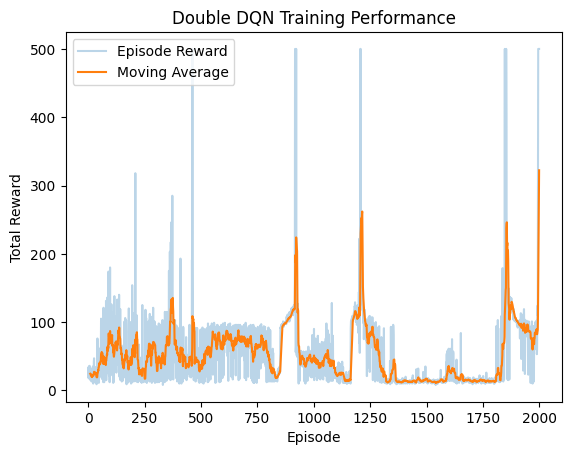

In [19]:
import matplotlib.pyplot as plt

window = 10
moving_avg = np.convolve(
    reward_list,
    np.ones(window)/window,
    mode="valid"
)

plt.plot(reward_list, alpha=0.3, label="Episode Reward")
plt.plot(range(window-1, len(reward_list)), moving_avg, label="Moving Average")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("Double DQN Training Performance")
plt.show()



Double DQN Evaluation

In [17]:
q_net.eval()
eval_reward_list = []
for i in range(10):
    eval_reward, frames = evaluate_and_record(env, q_net, device)
    eval_reward_list.append(eval_reward)

    video_path = f"./results/final_eval_ep{i}.mp4"
    imageio.mimsave(video_path, frames, fps=30)

    print(f"[FINAL EVAL] Episode {i} | Reward: {eval_reward:.2f} | Video saved: {video_path}")


Evaluation Reward:  500.00
[FINAL EVAL] Episode 0 | Reward: 500.00 | Video saved: ./results/final_eval_ep0.mp4


Evaluation Reward:  500.00
[FINAL EVAL] Episode 1 | Reward: 500.00 | Video saved: ./results/final_eval_ep1.mp4


Evaluation Reward:  500.00
[FINAL EVAL] Episode 2 | Reward: 500.00 | Video saved: ./results/final_eval_ep2.mp4


Evaluation Reward:  500.00
[FINAL EVAL] Episode 3 | Reward: 500.00 | Video saved: ./results/final_eval_ep3.mp4


Evaluation Reward:  500.00
[FINAL EVAL] Episode 4 | Reward: 500.00 | Video saved: ./results/final_eval_ep4.mp4


Evaluation Reward:  500.00
[FINAL EVAL] Episode 5 | Reward: 500.00 | Video saved: ./results/final_eval_ep5.mp4


Evaluation Reward:  500.00
[FINAL EVAL] Episode 6 | Reward: 500.00 | Video saved: ./results/final_eval_ep6.mp4


Evaluation Reward:  500.00
[FINAL EVAL] Episode 7 | Reward: 500.00 | Video saved: ./results/final_eval_ep7.mp4


Evaluation Reward:  500.00
[FINAL EVAL] Episode 8 | Reward: 500.00 | Video saved: ./results/final_eval_ep8.mp4


Evaluation Reward:  500.00
[FINAL EVAL] Episode 9 | Reward: 500.00 | Video saved: ./results/final_eval_ep9.mp4


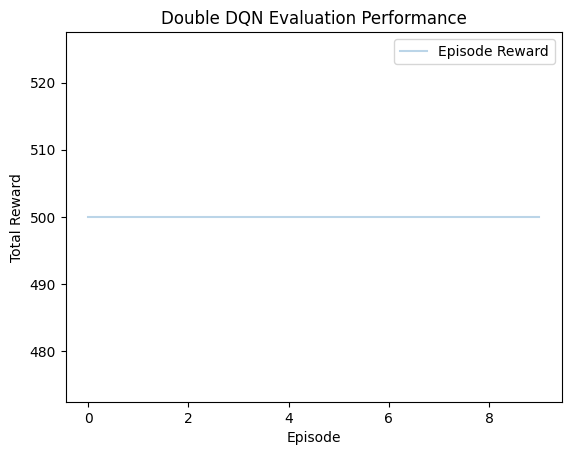

In [18]:
import numpy as np

plt.plot(eval_reward_list, alpha=0.3, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("Double DQN Evaluation Performance")
plt.show()


In [20]:
!zip -r results.zip results
from google.colab import files
files.download("results.zip")

  adding: results/ (stored 0%)
  adding: results/eval_ep1500.mp4 (deflated 20%)
  adding: results/final_eval_ep1.mp4 (deflated 16%)
  adding: results/eval_ep300.mp4 (deflated 13%)
  adding: results/eval_ep900.mp4 (deflated 14%)
  adding: results/eval_ep500.mp4 (deflated 13%)
  adding: results/eval_ep100.mp4 (deflated 18%)
  adding: results/final_eval_ep3.mp4 (deflated 16%)
  adding: results/eval_ep1400.mp4 (deflated 19%)
  adding: results/eval_ep1600.mp4 (deflated 14%)
  adding: results/eval_ep600.mp4 (deflated 15%)
  adding: results/eval_ep0.mp4 (deflated 22%)
  adding: results/eval_ep1000.mp4 (deflated 19%)
  adding: results/final_eval_ep8.mp4 (deflated 16%)
  adding: results/eval_ep200.mp4 (deflated 13%)
  adding: results/final_eval_ep0.mp4 (deflated 16%)
  adding: results/final_eval_ep2.mp4 (deflated 16%)
  adding: results/eval_ep1200.mp4 (deflated 48%)
  adding: results/eval_ep1800.mp4 (deflated 16%)
  adding: results/final_eval_ep9.mp4 (deflated 17%)
  adding: results/eval_ep700.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>